In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
from IPython import display

In [1]:
import torch
import sys
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(USE_CUDA)

False


In [3]:
# this is a utility file developed by the author
from utils import Logger

In [4]:
# the following will download and proces the MNIST dataset: http://yann.lecun.com/exdb/mnist/
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784  # the input size for each image is 28x28=784
        n_out = 1  # one dropout layer to prevent overfitting
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
# convert a flattened image into its 2-dimensional representation, and another one that does the opposite
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [7]:
class GeneratorNet(torch.nn.Module):
    """a three hidden-layer generative neural netwrok"""
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x



In [8]:
def noise(size):
    """generates a 1-d vector of gaussian sampled random values"""
    n = Variable(torch.randn(size, 100))
    return n

In [9]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

In [10]:
# optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss Function

loss = nn.BCELoss()

In [11]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [12]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # reset gradients
    optimizer.zero_grad()
    
    # 1.1 train on real data
    prediction_real = discriminator(real_data)
    # calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()
    
    # 1.2 train on fake data
    prediction_fake = discriminator(fake_data)
    # calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    #1.3 update weights with gradients
    optimizer.step()
    
    # return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake
    

In [13]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    
    # reset gradients
    optimizer.zero_grad()
    
    # sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    # calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    
    # update weights with gradients
    optimizer.step()
    
    # return error
    return error

In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples)

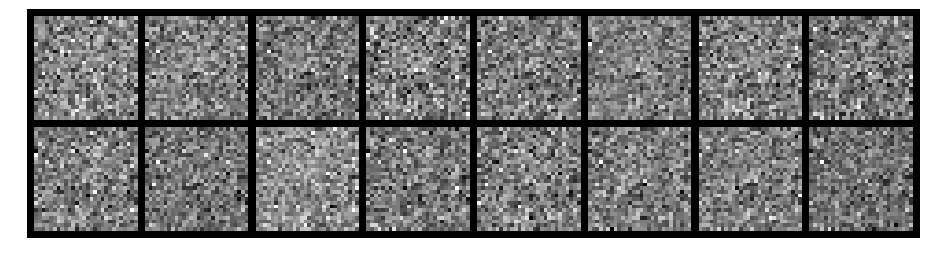

Epoch: [0/2], Batch Num: [0/600]
Discriminator Loss: 1.3453, Generator Loss: 0.6945
D(x): 0.5206, D(G(z)): 0.4996


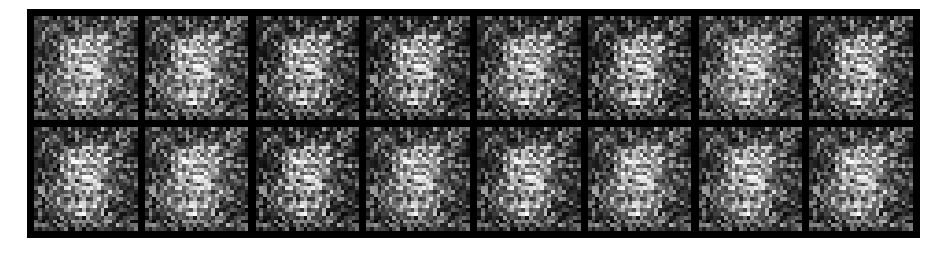

Epoch: [0/2], Batch Num: [100/600]
Discriminator Loss: 1.9485, Generator Loss: 0.8117
D(x): 0.6769, D(G(z)): 0.7359


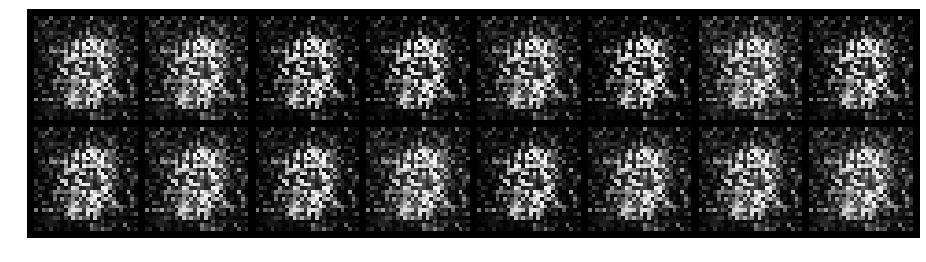

Epoch: [0/2], Batch Num: [200/600]
Discriminator Loss: 0.9877, Generator Loss: 2.1271
D(x): 0.6923, D(G(z)): 0.3942


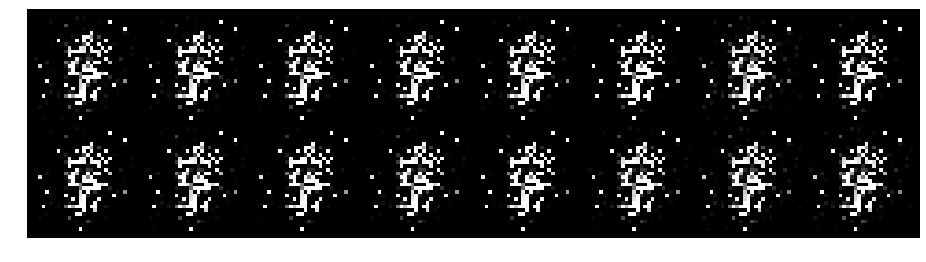

Epoch: [0/2], Batch Num: [300/600]
Discriminator Loss: 0.0911, Generator Loss: 6.2479
D(x): 0.9897, D(G(z)): 0.0686


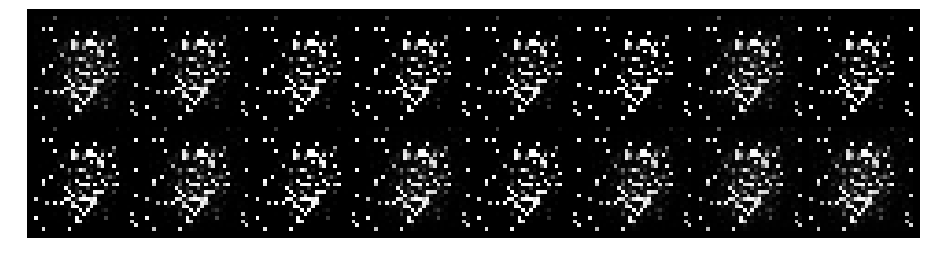

Epoch: [0/2], Batch Num: [400/600]
Discriminator Loss: 0.0954, Generator Loss: 7.0465
D(x): 0.9417, D(G(z)): 0.0230


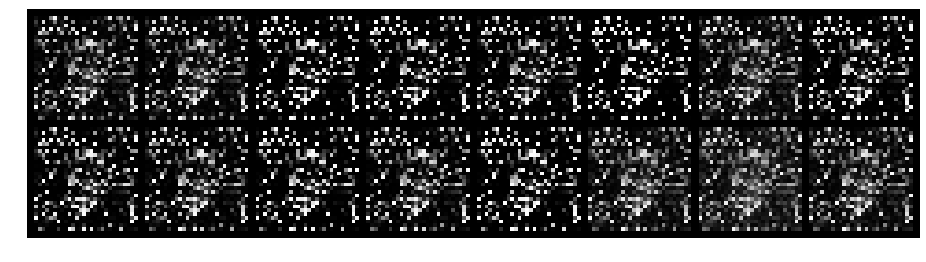

Epoch: [0/2], Batch Num: [500/600]
Discriminator Loss: 0.3132, Generator Loss: 4.9977
D(x): 0.8290, D(G(z)): 0.0963


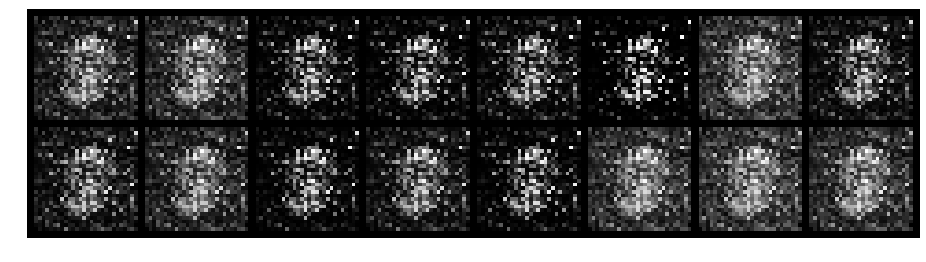

Epoch: [1/2], Batch Num: [0/600]
Discriminator Loss: 0.1981, Generator Loss: 4.9395
D(x): 0.9387, D(G(z)): 0.1055


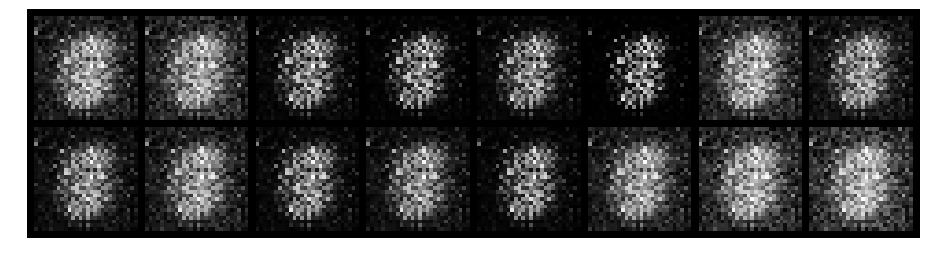

Epoch: [1/2], Batch Num: [100/600]
Discriminator Loss: 0.1752, Generator Loss: 4.6679
D(x): 0.9441, D(G(z)): 0.0884


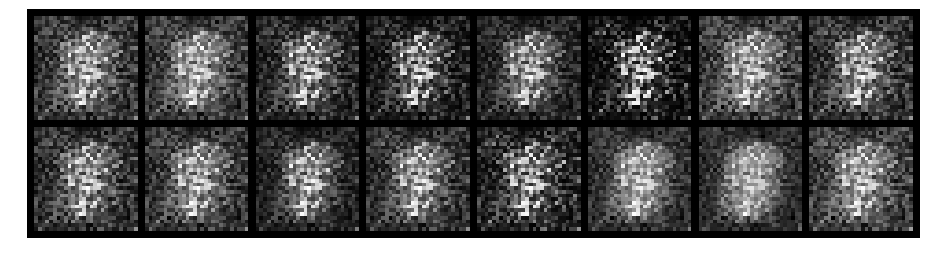

Epoch: [1/2], Batch Num: [200/600]
Discriminator Loss: 1.0859, Generator Loss: 1.9240
D(x): 0.8435, D(G(z)): 0.5221


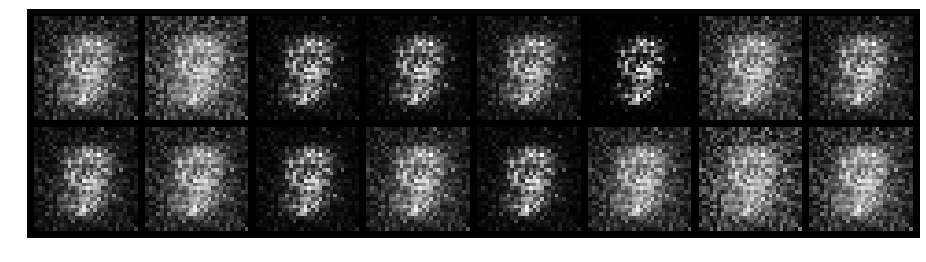

Epoch: [1/2], Batch Num: [300/600]
Discriminator Loss: 0.4845, Generator Loss: 1.9499
D(x): 0.8552, D(G(z)): 0.2327


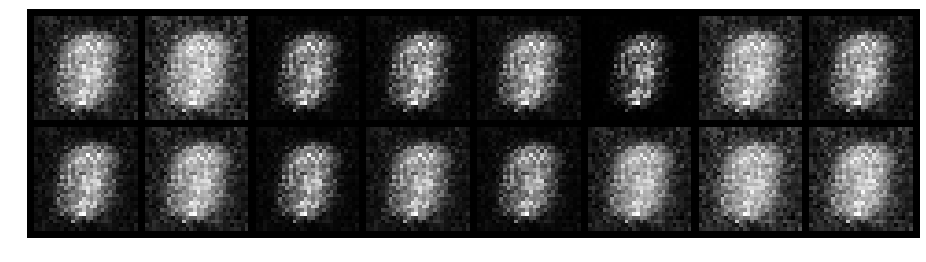

Epoch: [1/2], Batch Num: [400/600]
Discriminator Loss: 1.1417, Generator Loss: 1.3583
D(x): 0.5489, D(G(z)): 0.3355


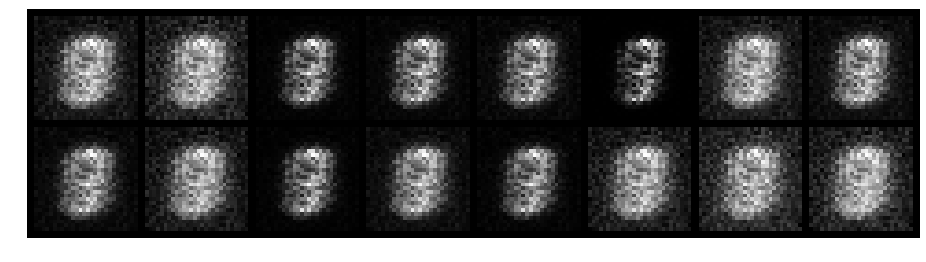

Epoch: [1/2], Batch Num: [500/600]
Discriminator Loss: 0.5168, Generator Loss: 1.6535
D(x): 0.8058, D(G(z)): 0.2296


In [15]:
# create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        # train discriminator
        readl_data = Variable(images_to_vectors(real_batch))
        
        # generating fake data and detach so gradients are not calculated for generator
        fake_data = generator(noise(N)).detach()
        
        # train
        d_error, d_pred_real, d_pred_fake = \
            train_discriminator(d_optimizer, readl_data, fake_data)
        
        # train generator
        
        #generate fake data
        fake_data = generator(noise(N))
        
        # train g
        g_error = train_generator(g_optimizer, fake_data)
        
        # log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # display progress every few batches
        if (n_batch) % 100 == 0:
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            
            logger.log_images(
                test_images, num_test_samples,
                epoch, n_batch, num_batches
            )
            
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )